### Preprocesamiento

In [1]:
!pip install tensorflow-datasets==1.2.0

     |████████████████████████████████| 2.3MB 10.1MB/s 
  Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [2]:
from google.colab import files
from google.colab import drive
from os.path import join
ROOT = '/content/drive'
drive.mount(ROOT)

Mounted at /content/drive


In [3]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer, Dense, LSTM, Bidirectional, TimeDistributed
import tensorflow.keras.backend as K
import pandas as pd
import pickle
from random import randint

In [4]:
# Definimos algunos parámetros e hyper-parámetros de nuestro modelo

BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_LENGTH = 32
NUM_LAYERS = 6
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.2
LATENT_SPACE = 32
A = 0.0000001 # Pendiente de función que pondera el peso de la kl_loss a lo largo de los entrenamientos
B = 0.00001 # determina el peso de la kl_loss al comienzo del entrenamiento 

tf.random.set_seed(1234)
pd.options.display.max_colwidth = 100

In [5]:
# Traemos el repositorio de git
PROJ = '/content/repository/'
PROJECT_PATH = join(ROOT, PROJ)

GIT_USERNAME = "Adrok24"
GIT_REPOSITORY = "Proyecto-T-VAE"

!rm -r "{PROJECT_PATH}"
!mkdir '{PROJECT_PATH}'
!git clone https://github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git "{PROJECT_PATH}"

rm: cannot remove '/content/repository/': No such file or directory
Cloning into '/content/repository'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 418 (delta 123), reused 100 (delta 40), pack-reused 198
Receiving objects: 100% (418/418), 52.62 MiB | 17.24 MiB/s, done.
Resolving deltas: 100% (205/205), done.


In [6]:
# Instanciamos el init que se encarga de levantar todas nuestras librerías personalizadas
from importlib.machinery import SourceFileLoader
problem_module = SourceFileLoader('tvae_module', join(PROJECT_PATH,'tvae_model/__init__.py')).load_module()

from tvae_module import *

In [7]:
## Cargamos nuestro Dataset
DRIVE_FOLDER = '/content/drive/My Drive/Colab Notebooks/desafio final/'

path_to_corpus = os.path.join(DRIVE_FOLDER, 'train_corpus_v3.csv')
path_to_corpus

'/content/drive/My Drive/Colab Notebooks/desafio final/train_corpus_v3.csv'

In [8]:
data = pd.read_csv(path_to_corpus, index_col=0)

In [9]:
data.sample(10)

line  ...  Sentimiento
174454         de repente  ,  @name se acordó de la teoría de la fusión de la que él tanto le había hablado  ...          NEU
192743                                                          @name te traiga toda la felicidad del mundo  ...          POS
336005                                         no podía pasarse el resto de su vida llorando  ,   ¿ o sí  ?  ...          NEG
343523                       ¿ cómo haría para entregárselo a aquella mujer si no tenía otra alternativa  ?  ...          NEG
21207                     pero si estoy apenas en la casilla tres  ,  y a cada rato tiro la piedrita afuera  ...          NEG
40353              sería como vivir sujeto a un pararrayos en plena tormenta y creer que no va a pasar nada  ...          NEG
11780                                el pobre @name empezará a lamentar muy pronto haberme embarcado con él  ...          NEG
268608                                                              eso no me parece muy adecuado  ,  @name  ...          NEG
203816                                        una tarde que joe pasó en casa  ,  @name intentó explicárselo  ...          NEG
16918   @name muchas palabras que se refieren a las drogas pero en general es en slang y mescaline puede...  ...          NEU

[10 rows x 6 columns]

In [10]:
data.shape

(316618, 6)

In [11]:
## tokenizador de subwords
path_to_tokenizer = os.path.join(DRIVE_FOLDER, 'tokenizer.pkl')
with open(path_to_tokenizer, 'rb') as tk_pkl:
        tokenizer = pickle.load(tk_pkl)

In [12]:
# Usamos train_test_split() para filtrar el volumen de lineas que le vamos a pasar al entrenamiento
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['line', 'len', 'book', 'Sentimiento']], data['genre'], test_size=0.05, random_state=42, stratify=data['genre'])
print('X_train: ',X_train.shape, 'X_test: ',X_test.shape, 'y_train: ',y_train.shape, 'y_test: ',y_test.shape)

X_train:  (300787, 4) X_test:  (15831, 4) y_train:  (300787,) y_test:  (15831,)


In [13]:
data_train = pd.concat([X_train, y_train],axis=1)
data_test = pd.concat([X_test, y_test],axis=1)

In [14]:
VOCAB_SIZE = tokenizer.vocab_size

In [15]:
data_tokens = tokenize_and_filter_df(data_train, tokenizer, MAX_LENGTH)
data_tokens_test = tokenize_and_filter_df(data_test, tokenizer, MAX_LENGTH)

In [16]:
display(data_tokens.sample(3))
display(data_tokens_test.sample(3))

line  ... sent
83377   pero estaba claro que la mujer sabía quién era y que no estaba dispuesta a dejar las cosas así  ...  NEG
160161                                                         quería disimular el dolor de su corazón  ...  NEG
188092               se trata de bestiario  ,  y fue hecha en buenos @name por un señor que no conozco  ...  NEU

[3 rows x 5 columns]

line  ... sent
10923  su ropa tal vez hubiera mejorado  ,  pero sus rubios cabellos seguían tan alborotados como el dí...  ...  NEG
5647                                        @name una forma de decirle que respetaba su trabajo como madre  ...  POS
4948   brad no había visto nunca a una mujer tan hermosa como @name y  ,  al mirarla  ,  le dolía el co...  ...  NEG

[3 rows x 5 columns]

In [17]:
# Aplicamos un padding con nuestro MAX_LENGTH
data_lines = tf.keras.preprocessing.sequence.pad_sequences(
    data_tokens.secuence.tolist(), maxlen=MAX_LENGTH, padding='post')

data_lines_test = tf.keras.preprocessing.sequence.pad_sequences(
    data_tokens_test.secuence.tolist(), maxlen=MAX_LENGTH, padding='post')

data_tokens['secuence'] = data_lines.tolist()
data_tokens_test['secuence'] = data_lines_test.tolist()

display(data_tokens.sample(3))
display(data_tokens_test.sample(3))

line  ... sent
148807                                       haz venir a ese francés idiota para ayudar  ,  si es necesario  ...  NEG
168591                              agradecido  ,  aunque ya con una sombra de desdén  ,  él no perdió nada  ...  NEU
38610   no  ,  no  .   .   .  es sólo que echo mucho de menos a las hermana s explicó ella con lágrimas ...  ...  NEG

[3 rows x 5 columns]

line  ... sent
15482  @name a verle con sus familias una vez cada varios años por obligación  ,  y lo consideraban tod...  ...  NEU
9287   contaban respectivamente uno  ,  cinco y nueve años cuando les perdí la pista  ,  y no tengo ide...  ...  NEG
14708  casi los tenían encima y el impulso de gritar era abrumador  ,  pero @name se obligó a callar y ...  ...  NEG

[3 rows x 5 columns]

In [18]:
print('Tamaño vocabulario: {}'.format(VOCAB_SIZE))
print('frases: {}'.format(len(data_lines)))

Tamaño vocabulario: 8189
frases: 296686


In [19]:
# Instanciamos el Encoder y Decoder
encoder = encoder(VOCAB_SIZE, NUM_LAYERS, UNITS, D_MODEL, NUM_HEADS, DROPOUT, LATENT_SPACE, MAX_LENGTH)
decoder = decoder(VOCAB_SIZE, NUM_LAYERS, UNITS, D_MODEL, NUM_HEADS, DROPOUT, LATENT_SPACE, MAX_LENGTH)

# Instanciamos el modelo
model = VAEModel(
      encoder,
      decoder,
      a=A,
      b=B,
      vocab_size=VOCAB_SIZE,
      num_layers=NUM_LAYERS,
      units=UNITS,
      d_model=D_MODEL,
      num_heads=NUM_HEADS,
      dropout=DROPOUT,
      latent_space=LATENT_SPACE,
      tokenizer=tokenizer)

# Ploteamos el grafo del Encoder/Decoder

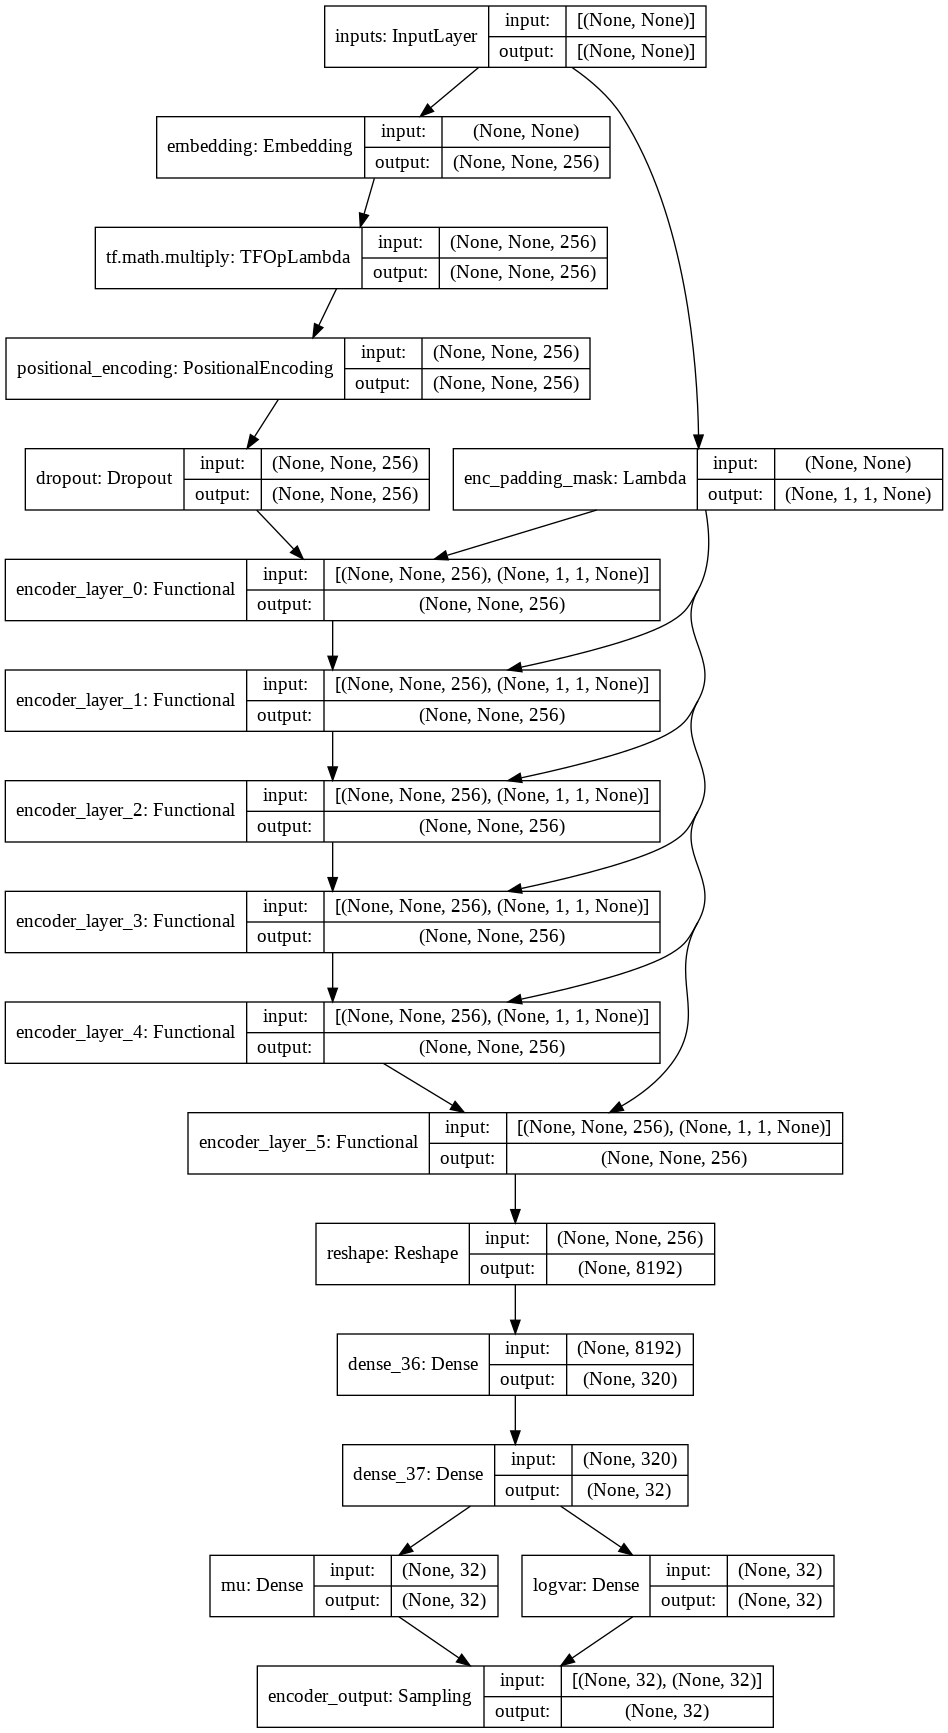

In [20]:
tf.keras.utils.plot_model(encoder, show_shapes=True)

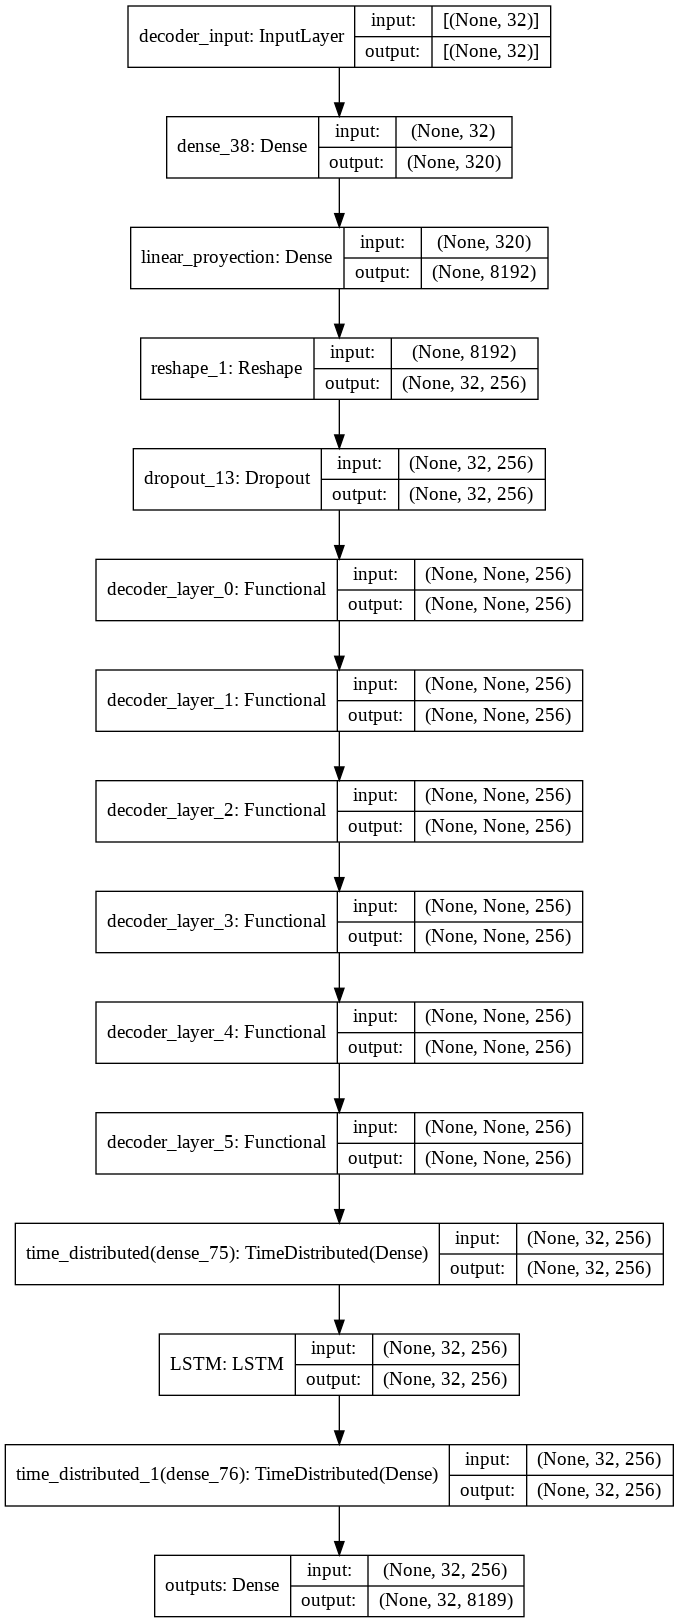

In [21]:
tf.keras.utils.plot_model(decoder, show_shapes=True)


# Cargamos el modelo

In [51]:
weights_normal = 'weights_normal.HDF5'

model.load_weights(join(DRIVE_FOLDER, weights_normal)) # Levantamos un modelo pre entrenado

# Generacion de frases de samples aleatorios

In [52]:
generate_from_normal(model, 1, LATENT_SPACE)[0]


'quería volvía a ponerse al margen de ante ella'

# Reconstruccion de frases definidas por el usuario

# Análisis

In [58]:
model.reconstruct_sentence("desde luego , cuando se hace bien es precioso", silent_reconstruct=True)
print('\n')
model.reconstruct_sentence("un hombre observaba desde el monte", silent_reconstruct=True) 

Reconstr:  ni en mi bondad yo se hay nada en contra
Original:  desde luego , cuando se hace bien es precioso


Reconstr:  el vino permanecía por el local
Original:  un hombre observaba desde el monte


# Recorriendo frases intermedias generadas a partir de una frase origen y una destino

## Funciones

In [59]:
def encode_sentence(sentence):
    sentence = [sentence]
    sentence = tokenize_and_filter(sentence, tokenizer, MAX_LENGTH)
    sentence = sentence.reshape(MAX_LENGTH)
    return sentence

In [60]:
# Genera una funcion que se mueve por el espacio latente desde Oracion A hasta Oracion B
# Si to_vector=True Sample2 debe ser el vector de llegada
def linear_interpolate(sample1, sample2, cant_sentences = 5, to_vector=False, remove_duplicated_words=True):

  print('desde:', tokenizer.decode(sample1),'\n')

  _,_,result1 = model.encoder(sample1.reshape(1,MAX_LENGTH,1))


  if (to_vector == False):
    _,_,result2 = model.encoder(sample2.reshape(1,MAX_LENGTH,1))

  #Resto los valores del espacio latente y los divido por la cantidad de oracione que quiero generar
  

  if (to_vector):
    vector = ((result1[0] - sample2).numpy()) / cant_sentences 
  else:
    vector = ((result1[0] - result2[0]).numpy()) / cant_sentences 

  str_sample_old = ""
  for i in range(cant_sentences):
    result_int = result1 - vector * i
    str_sample = model.decode_sample(result_int, silent_reconstruct=True)

    # Si el sampling no falla...
    if (str_sample != None):

      # Remuevo caracteres duplicados para limpiar el resultado
      if (remove_duplicated_words):
        list_split = str_sample.split(' ')
        new_string = list_split[0] + " "
        for index in range(1, len(list_split)):
          new_string += list_split[index] + " " if list_split[index] != list_split[index - 1] else ""

        str_sample = new_string.strip()

      if (str_sample != str_sample_old):
        print('step', str(i + 1) + ':', str_sample)
      str_sample_old = str_sample      

  print('')
  if (to_vector == False):
    print('hasta:', tokenizer.decode(sample2))


## Análisis

In [64]:
# Generar oraciones intermedias desde una oración A hasta una B sampleadas del entrenamiento
q_sample1 = data_lines[randint(0,data_lines.shape[0]) - 1]
q_sample2 = data_lines[randint(0,data_lines.shape[0]) - 1]

print(tokenizer.decode(q_sample1))
print(tokenizer.decode(q_sample2))

todos me parecen cortados por el mismo patrón
el cuerpo le dolía demasiado  ,  era algo apenas soportable


In [65]:
linear_interpolate(q_sample1, q_sample2,6)

desde: todos me parecen cortados por el mismo patrón 

step 1: nosotros me parecen buscado por el peor patrón
step 2: lópez por un discutiría para su bienconformó
step 3: aquella en el discurste que tenía una gran estrella
step 4: algo sobre la rosa belleza que llevaba el vez alto
step 5: al bien a sus manos y parecía ver la fatiga
step 6: el uno había traído demasiado  ,  todo tan a temblarlo

hasta: el cuerpo le dolía demasiado  ,  era algo apenas soportable


In [66]:
# OPCION A
q_sample1 = encode_sentence("hay que matar a todos")
q_sample2 = encode_sentence("voy que salvar a alguien")

linear_interpolate(q_sample1, q_sample2,50)

desde: hay que matar a todos 

step 1: tienes que empezar a hablar mismo
step 3: tienes que empezar a mí mismo
step 6: tienes que empezar a ti mismo
step 10: tienes que empezar o ti contigo
step 11: tienes que renunciar o algo contigo
step 15: siento que renunciar o algo contigo
step 16: siento que cuidar o algo contigo
step 24: siento que lograro contigo
step 25: siento que lograr contigo
step 26: siento que conoces contigo
step 29: siento que conoces de contigo
step 32: siento que conoces de todo
step 42: seguro que conoces de todo
step 44: seguro que conoces aquí alguien
step 45: seguro que conoces a alguien
step 47: pensar que conoces a alguien
step 49: deseo que conoces a alguien

hasta: voy que salvar a alguien


In [69]:
# OPCION B
q_sample1 = encode_sentence("un hombre observaba desde el monte")
q_sample2 = encode_sentence("el niño sonrió lentamente")

linear_interpolate(q_sample1, q_sample2,50)

desde: un hombre observaba desde el monte 

step 1: el silencio permanecía por el coche
step 6: el silencio permanecía en el coche
step 7: el silencio permanecía en el dormitorio
step 8: el silencio muerto en el dormitorio
step 12: el silencio asomó en el interior
step 15: el silencio asomó en el alrededor
step 16: el individuo asomó en el alrededor
step 19: el individuo asomó a el alrededor
step 20: el individuo asomó a su alrededor
step 21: el niño saltó sobre su alrededor
step 26: el chico saltó sobre su cama
step 28: el chico momentos sobre su garganta
step 29: el inspector momentos sobre su garganta
step 30: el inspector momentos de su seguridad
step 31: el inspector miró de su cabeza
step 36: el inspector miró hacia su espalda
step 37: el inspector miró hacia la espalda
step 40: el inspector miró hacia la risa
step 44: el chico miró hacia la verlo
step 46: el chico miró mirándole fijamente
step 48: el chico asintió mirándole fijamente
step 49: el chico asintió mirándole

hasta: e

# Generamos un vector de Poesía y lo recorremos

## Funciones

In [70]:
# Generamos las predicciones de todo nuestro set de entrenamiento
z_mean, z_signa, z_sample = model.encoder.predict(data_tokens_test.secuence.tolist())

## Análisis

In [71]:
poetry_mask = data_tokens_test['genre'] == 'poesía'
poetry_rows = z_mean[poetry_mask]
print('poetry rows shape:', poetry_rows.shape)
poetry_vec = np.mean(poetry_rows, axis=0)
print('poetry vector shape:', poetry_vec.shape)

poetry rows shape: (900, 32)
poetry vector shape: (32,)


In [72]:
# OPCIÓN A
q_sample1 = encode_sentence("estamos llegando a la estacion de tren")
linear_interpolate(q_sample1, poetry_vec,5,True)

desde: estamos llegando a la estacion de tren 

step 1: estamos llegando a la galería de char
step 2: la doce ción de la mina de montañas
step 3: la mayor parte de su terminaría la primavera
step 4: de los días tendremos muy calor el menos dav
step 5: a un momento justo el otro frente el árbol algo



In [73]:
# OPCIÓN B
q_sample1 = encode_sentence("estaba sentado en el sofá de la sala")
linear_interpolate(q_sample1, poetry_vec,15,True)

desde: estaba sentado en el sofá de la sala 

step 1: estaba sentado en el borde de la sala
step 2: estaba sentado en el borde de la acera
step 4: en seguida a el borde de la acera
step 5: en seguida oyó el borde de la diligencia
step 6: en seguida oyó el paso de la oscuridad
step 7: en uno oyó el paso hacia la oscuridad
step 8: fue uno de una paso hacia la tormenta
step 9: fue uno de una hora hacia la lejana
step 10: fue vez de una hora hacia la gracia
step 11: fue al hacia una mano más la primera a
step 12: fue al menos una mano más su primera sonriendo
step 13: fue el otra cada hombre más su niño dándole
step 14: todo el otra cada vez algo el hombre dándole su
step 15: todo el otra cada vez dios el hombre dándole otra vez



In [74]:
# obtenemos una linea del genero filosofía y la pasamos por el vector
filosofia_mask = data_tokens_test.genre == 'filosofia'
data_tokens_test[filosofia_mask].shape
filosofia_sample = data_tokens_test[filosofia_mask].line.tolist()[randint(0,data_tokens_test[filosofia_mask].shape[0]) - 1]
filosofia_sample = encode_sentence(filosofia_sample)
linear_interpolate(filosofia_sample, poetry_vec,5,True)

desde: cuando le llegue al hombre  ,  éste dejará de ser un animal histórico 

step 1: esto le da el brazo  ,  usted dejaá de ser un oro histórico
step 2: como te viene el anterior  ,  es primera vez de ser un miedo espectacula
step 3: usted ha sido el daño que quiera querer mal más lejos un sus palabras
step 4: ojalá pudiera mí el mar en la cabeza veía el una del cosa
step 5: es la mañana del hombre de su madre dándole una otra vez



# Similitud Coseno entre frases del Dataset


## Funciones

In [75]:
# Funcion para generar un un DataFrame de similitud coseno dada la metrica elegida
from sklearn.metrics.pairwise import cosine_similarity
def get_similarity(metric):
  lines_similarity = cosine_similarity(metric)
  return pd.DataFrame(lines_similarity,index=data_tokens_test['line'], columns=data_tokens_test['line'])

samples_similarity_df = get_similarity(z_mean)

In [76]:
# Permite buscar una linea y sus resultados mas cercanos por texto o por índice
def find_line(find_line, df, retunr_lines=10):
  if (type(find_line) == str):
    get_line = df[df.index.str.contains(find_line)].index[0]#.tema.iloc[0]
    return df.loc[get_line,:].sort_values(  ascending=False ).head(10)
  else:
    return df.iloc[find_line,:].sort_values(  ascending=False ).head(10)  

## Análisis

In [77]:
find_line(0, samples_similarity_df)

line
@name retrocedió  ,  le tomó la cara con las dos manos y la besó fuertemente en los labios         1.000000
se despertó sobresaltada y se agarró con fuerza a un brazo de @name                                0.749103
@name borland  ,  ya sin control sobre sus impulsos  ,  hizo acción de desenfundar                 0.694704
y fue deslizándose  ,  para situarse cerca de la vagoneta bajo la cual habían quedado las armas    0.651864
@name desmontó y se situó sobre un peñasco                                                         0.646157
pero en seguida asintió con la cabeza y giró sobre sus talones                                     0.617835
cuando volvió al hotel  ,  le pareció que lo había visto todo                                      0.617568
se cruzó de brazos y se apoyó en la elegante barandilla                                            0.614252
pero ni siquiera los que estaban en el pescante pensaban moverse                                   0.610799
le había comentado que 

# Plot 3D de z_mean, z_signa, z_sample

## Funciones

In [78]:
from sklearn.decomposition import PCA
import plotly.express as px

In [79]:
# Definimos una funcion para encontrar palabras clave en las frases de nuesto set de datos
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

def key_words_search_in_latent_space(dataset, list_words):
  dataset['words_search'] = dataset.line.apply(lambda x: len(intersection(x.split(' '), list_words) ) )

## Análisis

In [80]:
# Elige una métrica
metric = z_mean # z_mean, z_signa, z_sample

In [81]:
# Reducimos la dimencionalidad de nuestra métrica con PCA
pca_X = PCA(n_components=10)
pca_X.fit(metric)
df_pca = pd.DataFrame(pca_X.fit_transform(metric))

In [82]:
# Ploteamos nuestra metrica con el atributo que queramos ver

ATRIBUTO = 'len'

data_plot = data_tokens_test

x_coord = np.array(df_pca)[:,0].astype(float)
y_coord = np.array(df_pca)[:,1].astype(float)
z_coord = np.array(df_pca)[:,2].astype(float)    

marks_size = [2 for i in range(len(x_coord))]

fig = px.scatter_3d(x = x_coord, y = y_coord, z = z_coord, 
              color = data_plot[ATRIBUTO], opacity = 0.6, size = data_plot['len'],hover_name=data_tokens_test['line'])

fig.show()

# Analisis Visual del espacio latente

In [83]:
# Analisis Visual del espacio latente
def plot_label_clusters(vae, z_mean, labels=None, z_fixed=0):
  # display a 2D plot of the digit classes in the latent space
  ax_y = int(LATENT_SPACE / 4)
  fig, axes = plt.subplots(4, ax_y, figsize=(20,12))
  fig.subplots_adjust(hspace=0.4)
  z = 0
  colors = ['b', 'c', 'y', 'm']
  for x in range(4):
    for y in range(ax_y): 
      axes[x, y].scatter(z_mean[:, z_fixed], z_mean[:, z], c=labels)
      axes[x, y].set_xlabel("z["+ str(z_fixed) +"] | z["+ str(z) +"]") 
      # axes[x, y].ylabel("z["+ str(i) +"]")
      z += 1



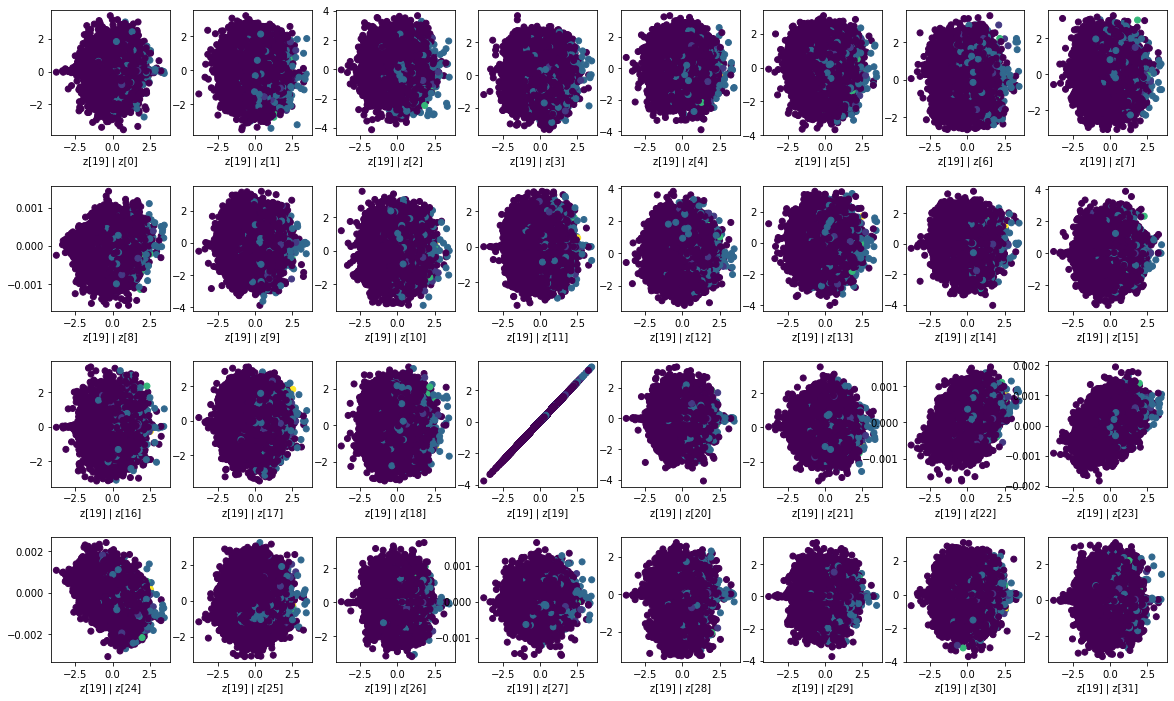

In [84]:
key_words_search_in_latent_space(data_tokens_test, ['!','¡','¿','?'])
plot_label_clusters(model, z_mean, data_tokens_test['words_search'], 19)

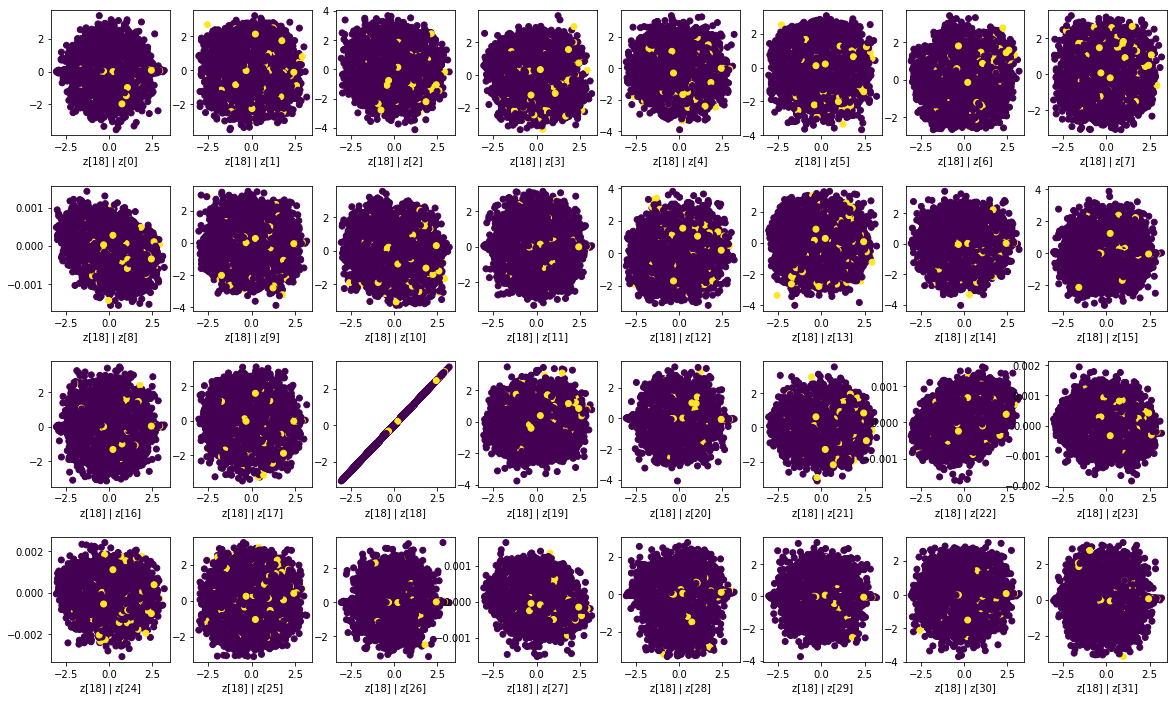

In [85]:
data_tokens_test['words_search'] = data_tokens_test['genre'].apply(lambda x: int(x == 'poesía') )
plot_label_clusters(model, z_mean, data_tokens_test['words_search'], 18)

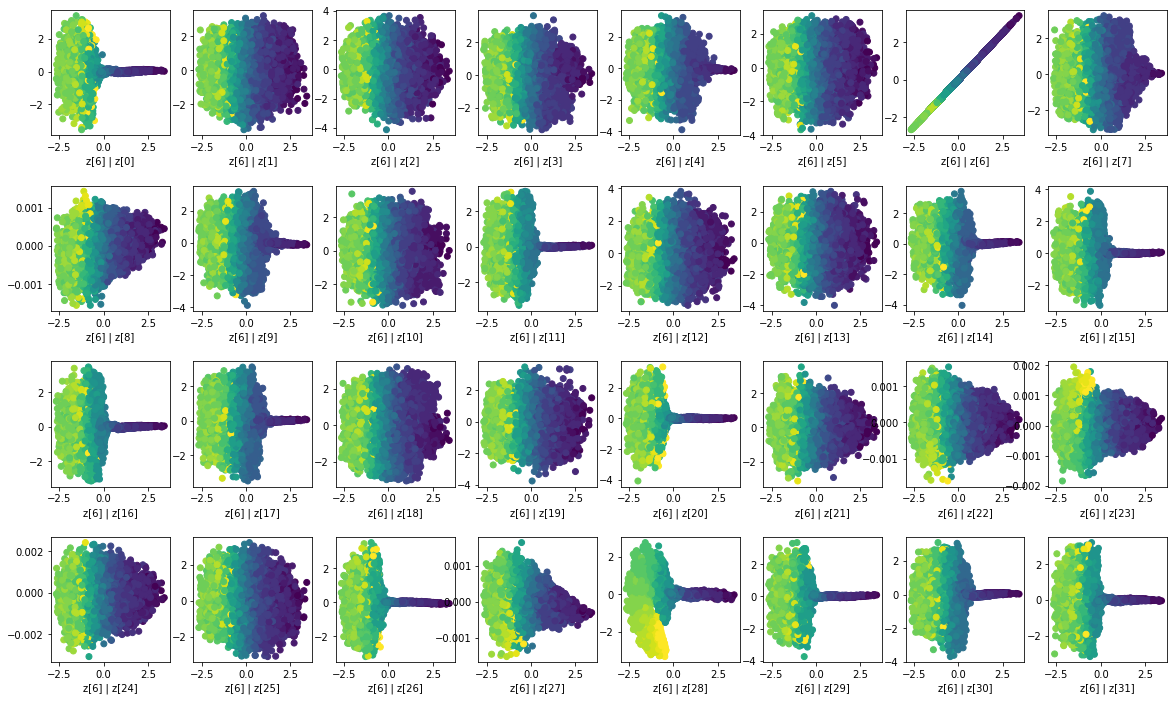

In [86]:
plot_label_clusters(model, z_mean, data_tokens_test['len'], 6)

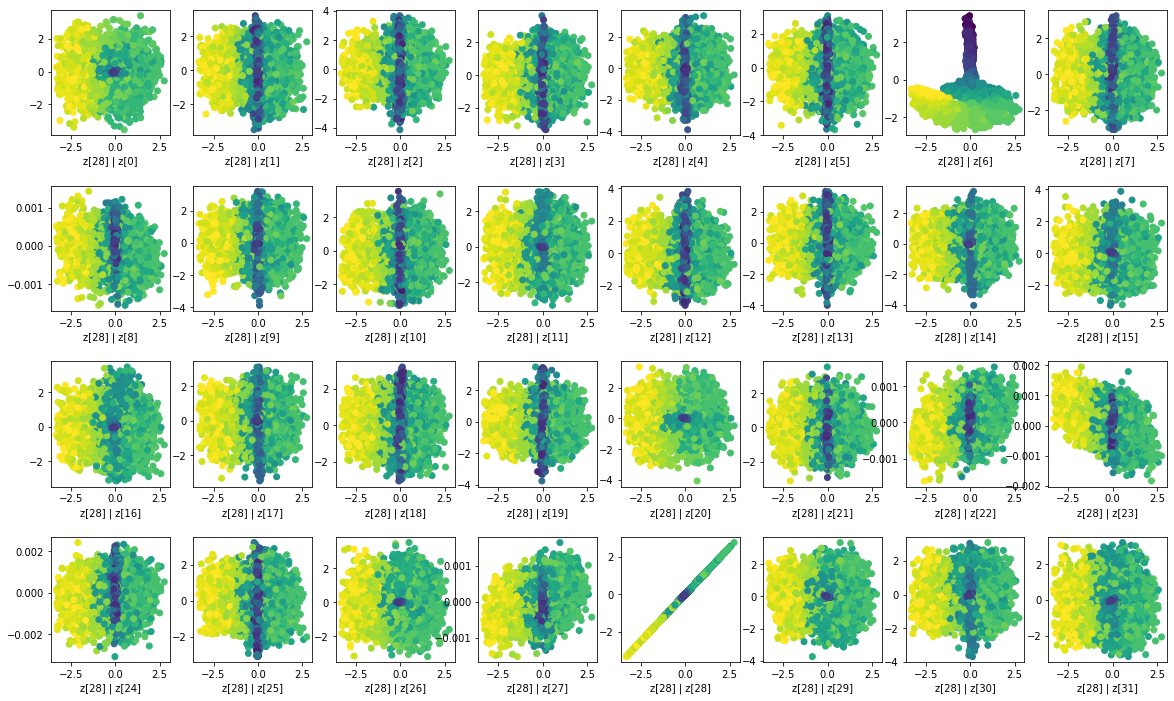

In [87]:
plot_label_clusters(model, z_mean, data_tokens_test['len'], 28)

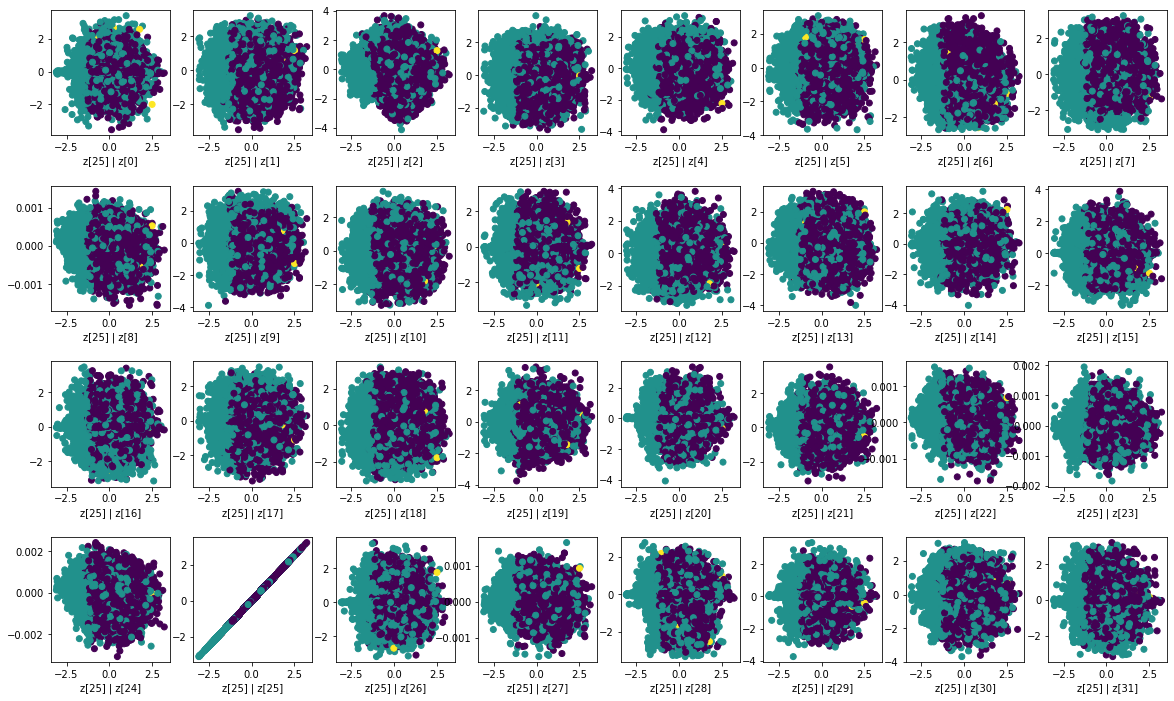

In [88]:
key_words_search_in_latent_space(data_tokens_test, ['@name'])
plot_label_clusters(model, z_mean, data_tokens_test['words_search'], 25)

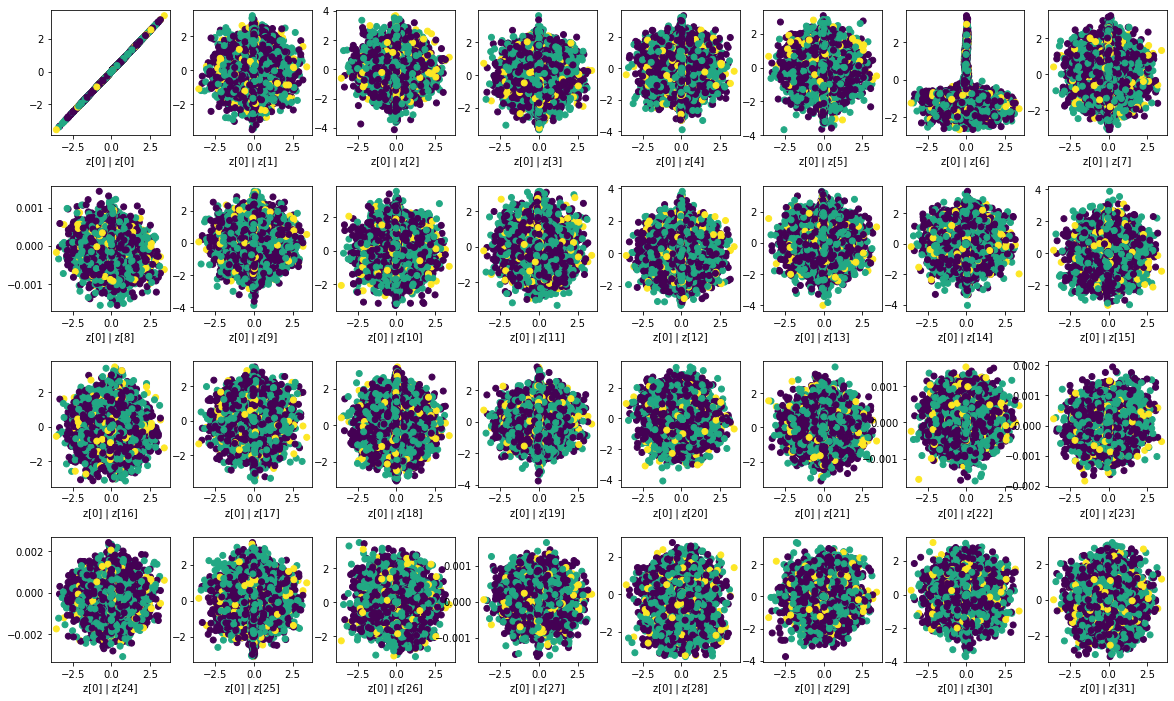

In [89]:
data_tokens_test['words_search'] = data_tokens_test['sent'].apply(lambda x: int(x.replace('NEG', '0').replace('NEU', '3').replace('POS', '5')))
plot_label_clusters(model, z_mean, data_tokens_test['words_search'], 0)

# WordClouds por atributos

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
stop_words_sp = set(stopwords.words('spanish'))

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop_words_sp,
        max_words=400,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()





Género: Novelas


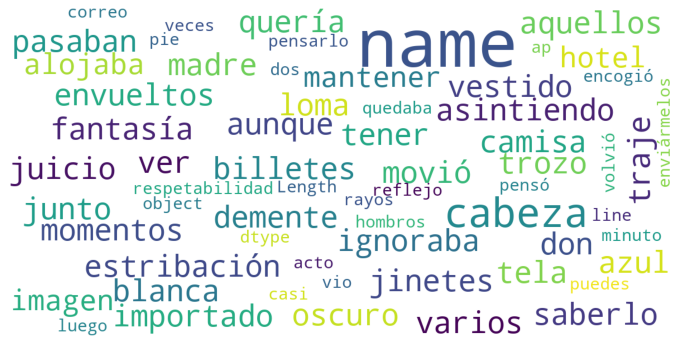



Género: cortazar


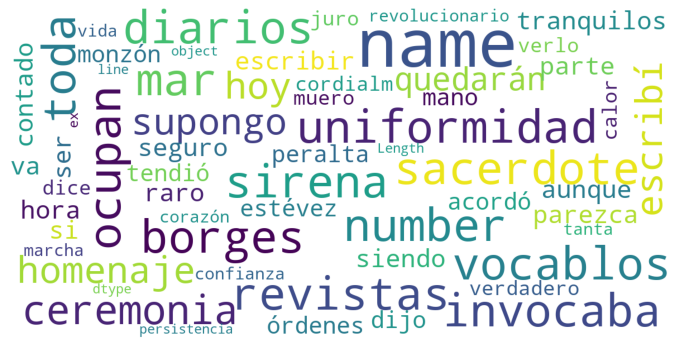



Género: poesía


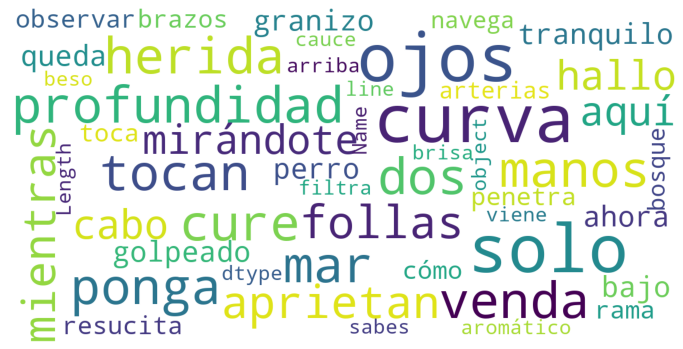



Género: filosofia


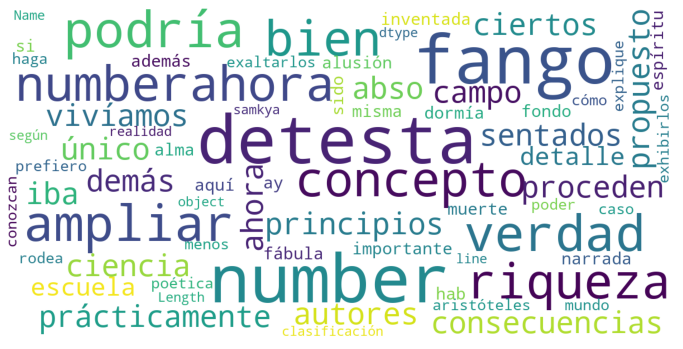

In [ ]:
for genero in data_tokens.genre.value_counts().index:
  print('\n')
  print('Género:',genero)
  show_wordcloud(data_tokens[data_tokens['genre'] == genero].line)



Sentimiento: NEG


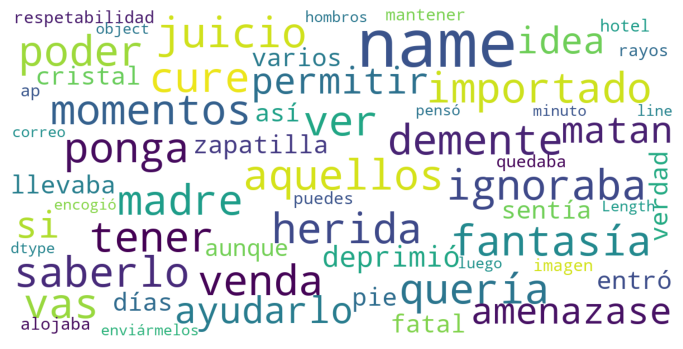



Sentimiento: NEU


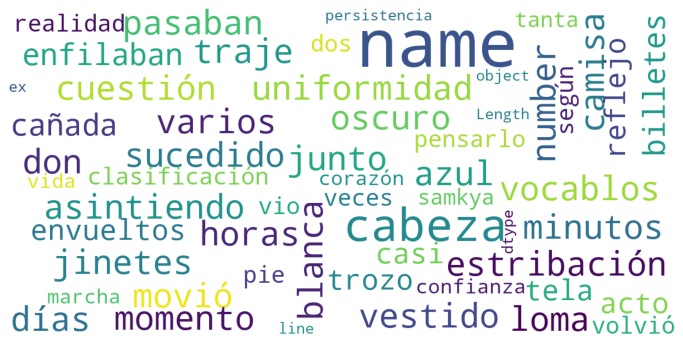



Sentimiento: POS


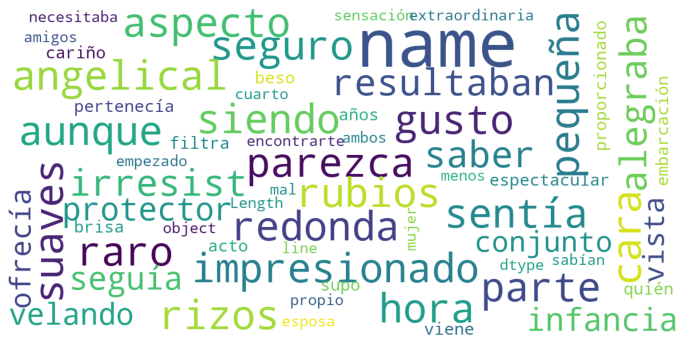

In [ ]:
for sent in data_tokens.sent.value_counts().index:
  print('\n')
  print('Sentimiento:',sent)
  show_wordcloud(data_tokens[data_tokens['sent'] == sent].line)